In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import additional library to properply play videos on jupyter notebook
from IPython.display import clear_output
import time
# %matplotlib inline
%config Completer.use_jedi = False
import copy
import datetime
from tqdm.notebook import tqdm

## The Area based stereo matching algorithm
####  In this algorithm with a rectified stereo pair a window of a fixed size is slided along the epipolar line to match each window from the refernce image to a set of windows on the other image and the match with with the minimum dissimillarity measure is choosen. The dissimilarity measure is the Sum of Absolute Differences (SAD). And since this calculation requires costly computation over the window slided on the image. Here is introduced the box filtering technique as explained in [1] So that reduce the computation complexity into five sums for each pixel in the image rather than the full window. In addition, subpixel refinement is done on the disparity map using a parbola interpolation between the SAD values. And lastly a bilateral filter is applied to the disparity map for further refinement

### Below is the code for the computation of the algorithm on the well-known tsubaka stereo pair. And Later in this notebook outliers are detected and removed by sharpness and distinctivness tests.

In [2]:
class StereoBM:
    ''' This class calculates the disparity map depending on a dissimilarity measure which is Sum of Absoulte Differences (SAD)
        Using a fixed-size window which is slided over the image to calculate that disparity of each pixel along the epipolar
        line. the required arguments for this class are the range of disparities (eg. [0, 128]), the kernel size, the size of the area to analyze
        at the center of the image and the offset of the disparity range (eg. [o, o+64]) respectively.
        
        numDisparities  --> the range of disparities ------------------------------------------------> int
        kernel_size     --> the size of a square kernel ---------------------------------------------> int
        mapSize         --> the size of the square area to be analyzed at the center of the image  --> int
        disparityOffset --> this arguments alters the disparity range to start with non-zero value --> int
    '''
    def __init__(self,numDisparities,kernel_size):
        # initialize the parameters for the computations
        self.corner = None
        self.kernelSize = (kernel_size-1)//2
        self.dr = numDisparities
        self.T = 60/100
        self.leftVar = None
        self.rightVar = None
        
        
    def compute(self,imgL,imgR):
        
        # convert the image into float and scale it
        if imgL.max()> 1:
            imgl = imgL.astype(np.float32)/255.0
        else:
            imgl = imgL.copy()
        if imgR.max()> 1:
            imgr = imgR.astype(np.float32)/255.0
        else:
            imgr = imgR.copy()
        # Computing the SAD
        dispMap = self.getSad(imgl,imgr)
        
        # Further refinement using bilateral filter
        ksize= 9
        sigmaVal = 75
        dispMap = cv2.bilateralFilter(dispMap.astype(np.uint8),ksize,sigmaVal,sigmaVal)
        return dispMap
    
    def getSad(self,imgL,imgR):
        # initializing the variables for the calculation and storage
        k = self.kernelSize
        sad = np.zeros((imgL.shape[0]-2*k-1,imgL.shape[1]-2*k-1,self.dr))-1
        dispImg = np.zeros((sad.shape[0],sad.shape[1]))
        
        # calculate and match for each column in the image
        for i in range(k,imgL.shape[1]-k-2):
            if i == k: # calculating for the first column is a little expensive
                dmax = min(self.dr,imgL.shape[1]-k-i-1) # to ensure that the matrix is index is not exceeded
                for d in range(0,dmax): 
                    # calculate for each d in the diparity range in the interval [0, damx]
                    # calculate the dissamillarity for the first pixel
                    sad[0,i-k,d] = np.abs(imgR[:2*k+1,i-k:i+k+1]-imgL[:2*k+1,i-k+d:i+k+1+d]).sum()
                    # then calculate the dissimillarity for the first column by taking the difference
                    # between the last column of the current window and the first column of the previous window
                    U = np.abs(imgR[2*k+2:,i-k:i+k+1]-imgL[2*k+2:,i-k+d:i+d+k+1]).sum(axis = 1)-\
                        np.abs(imgR[:-2*k-2,i-k:i+k+1]-imgL[:-2*k-2,i-k+d:i+d+k+1]).sum(axis =1)
                    sad[1:,i-k,d] = U
                    # calculating the sad of the first column at the current disparity value
                    sad[:,i-k,d] = np.cumsum(sad[:,i-k,d],axis = 0)
            else: # A great reduction in computation after the first row
                dmax = min(self.dr,imgL.shape[1]-k-i-1) # to ensure that the matrix is index is not exceeded
                for d in range(0,dmax): # calculate for each d in the diparity range in the interval [0, damx]
                    # calculate the SAD for the first row accross all disparities
                    U = np.abs(imgR[:2*k+1,i+k+1]-imgL[:2*k+1,i+k+1+d]).sum() -\
                        np.abs(imgR[:2*k+1,i-k-1]-imgL[:2*k+1,i-k-1+d]).sum()
                    sad[0,i-k,d] = U
                    # Just getting the index of the four points to calculate the next value
                    A = np.abs(imgR[2*k+2:,i+k+1]-imgL[2*k+2:,i+k+1+d])
                    B = np.abs(imgR[:-2*k-2,i+k+1]-imgL[:-2*k-2,i+k+1+d])
                    C = np.abs(imgR[2*k+2:,i-k-1]-imgL[2*k+2:,i-k-1+d])
                    D = np.abs(imgR[:-2*k-2,i-k-1]-imgL[:-2*k-2,i-k-1+d])
                    # Calculate the four sums of the acquired points
                    sad[1:,i-k,d] = A-B-C+D
                    # Calculate the fivth sum of the sad algorithm 
                    # and just using numpy.cumsum to calculate it accross the entire matrix
                    sad[:,i-k,d] = np.cumsum(sad[:,i-k,d],axis = 0)
                    sad[:,i-k,d] = sad[:,i-k,d] + sad[:,i-k-1,d]
                    
            # In the following the matching is done with sub-pixel refinement for each possible value of dmax.   
            if dmax > 1:
                a,minB = np.min(sad[:,i-k,:dmax],axis = 1), np.argmin(sad[:,i-k,:dmax],axis = 1)
            else:
                minB = np.zeros(sad.shape[0])
            if dmax < 3:
                dispImg[:,i-k] = minB
            else:
                indB = np.where(np.bitwise_and(minB>1, minB<(dmax-1)))[0]
                b = minB[np.bitwise_and(minB>1, minB<(dmax-1))]
                if b.shape[0]>0:
                    ind = np.arange(b.shape[0])
                    # sub-pixel refinement is done using parbola interpolation between the pixel disparities using sad values
                    dispImg[indB,i-k] = b-(0.5*(sad[indB,i-k,:dmax][ind,b+1]-sad[indB,i-k,:dmax][ind,b-1])/(sad[indB,i-k,:dmax][ind,b-1]-2*sad[indB,i-k,:dmax][ind,b]+sad[indB,i-k,:dmax][ind,b+1]))
                mask = np.zeros(sad.shape[0],dtype = np.uint8)
                indB = np.where(np.bitwise_or(minB<1, minB>=(dmax-1)))[0]
                b = minB[np.bitwise_or(minB<1, minB>=(dmax-1))]
                if b.shape[0]>0:
                    dispImg[indB,i-k] = b
        return dispImg

    

0:00:00.266802


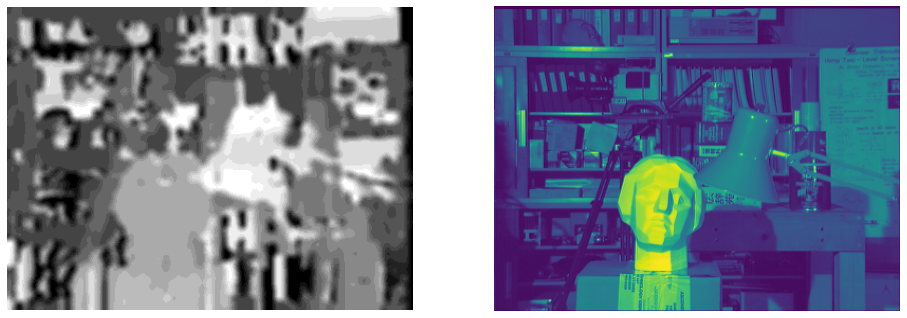

In [3]:
s = StereoBM(16,8)
t0 = datetime.datetime.now()
grayL = cv2.imread('Resources/TsukubaLeft.png',0)
grayR = cv2.imread('Resources/TsukubaRight.png',0)
disp = s.compute(grayL,grayR)
print(datetime.datetime.now()-t0)
disp = disp/16
plt.figure(figsize = (16,8))
plt.subplot(121)
plt.imshow(disp,cmap = 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(grayL)
plt.axis('off')
plt.show()

In [4]:
class StereoBM:
    ''' This class calculates the disparity map depending on a dissimilarity measure which is Sum of Absoulte Differences (SAD)
        Using a fixed-size window which is slided over the image to calculate that disparity of each pixel along the epipolar
        line. the required arguments for this class are the range of disparities (eg. [0, 128]), the kernel size, the size of the area to analyze
        at the center of the image and the offset of the disparity range (eg. [o, o+64]) respectively.
        
        numDisparities  --> the range of disparities    ---------------------------------------------> int
        kernel_size     --> the size of a square kernel ---------------------------------------------> int
        mapSize         --> the size of the square area to be analyzed at the center of the image  --> int
        disparityOffset --> this arguments alters the disparity range to start with non-zero value --> int
    '''
    def __init__(self,numDisparities,kernel_size,mapSize,disparityOffset = 0):
        self.corner = None
        self.kernelSize = (kernel_size-1)//2
        self.dr = numDisparities
        self.mapSize = mapSize
        self.T = 60/100
        self.leftVar = None
        self.rightVar = None
        self.o = int(disparityOffset)
        
        
    def compute(self,imgL,imgR):
        size = self.mapSize # load the required size of the disparity map at the ceneter of the image.
        # convert the image into float and scale it
        if imgL.max()> 1:
            imgl = imgL.astype(np.float32)/255.0
        else:
            imgl = imgL.copy()
        if imgR.max()> 1:
            imgr = imgR.astype(np.float32)/255.0
        else:
            imgr = imgR.copy()
#         leftVar = self.getVar(imgL)
#         rightVar = self.getVar(imgR)
        
        # Computing the SAD
        dispMap, sad = self.getSad(imgl,imgr)
        # Further refinement using bilateral filter
        ksize= 9
        sigmaVal = 75
        dispMap = cv2.bilateralFilter(dispMap.astype(np.uint8),ksize,sigmaVal,sigmaVal)
#         rightVar = rightVar[imgL.shape[0]//2-size[0]//2:imgL.shape[0]//2+size[0]//2,
#                             imgL.shape[1]//2-size[1]//2:imgL.shape[1]//2+size[1]//2]
#         leftVar = leftVar[imgL.shape[0]//2-size[0]//2:imgL.shape[0]//2+size[0]//2,
#                           imgL.shape[1]//2-size[1]//2:imgL.shape[1]//2+size[1]//2]
        return dispMap, sad

    def getSad(self,imgL,imgR):
        # initializing the variables for the calculation and storage
        size = self.mapSize
        k = self.kernelSize
        sad = np.zeros((size[0],size[1],self.dr))-1
        dispImg = np.zeros((size[0],size[1]))
        imgl = imgL[imgL.shape[0]//2-size[0]//2-k: imgL.shape[0]//2+size[0]//2+k+1,
                    imgL.shape[1]//2-size[1]//2-k: imgL.shape[1]//2+size[1]//2+k+1 + self.dr+self.o]
        
        imgr = imgR[imgL.shape[0]//2-size[0]//2-k: imgL.shape[0]//2+size[0]//2+k+1,
                    imgL.shape[1]//2-size[1]//2-k: imgL.shape[1]//2+size[1]//2+k+1]
        # calculate and match for each column in the image
        for i in range(k,imgr.shape[1]-k-1):
            if i == k: # calculating for the first column is a little expensive
                m = imgL.shape[0]-(imgL.shape[0]//2-size[0]//2-k)-i-1
                dmax = min(self.dr+self.o,m) # to ensure that the matrix is index is not exceeded
                for d in range(self.o,dmax): # calculate for each d in the diparity range in the interval [0, damx]
                    # calculate the dissamillarity for the first pixel
                    sad[0,i-k,d-self.o] = np.abs(imgr[:2*k+1,i-k:i+k+1]-imgl[:2*k+1,i-k+d:i+k+1+d]).sum()
                    # then calculate the dissimillarity for the first column by taking the difference
                    # between the last column of the current window and the first column of the previous window
                    U = np.abs(imgr[2*k+2:,i-k:i+k+1]-imgl[2*k+2:,i-k+d:i+d+k+1]).sum(axis = 1)-\
                        np.abs(imgr[:-2*k-2,i-k:i+k+1]-imgl[:-2*k-2,i-k+d:i+d+k+1]).sum(axis =1)
                    sad[1:,i-k,d-self.o] = U
                    # calculating the sad of the first column at the current disparity value
                    sad[:,i-k,d-self.o] = np.cumsum(sad[:,i-k,d-self.o],axis = 0)
            else: # A great reduction in computation after the first row
                m = imgL.shape[0]-(imgL.shape[0]//2-size[0]//2-k)-i-1
                dmax = min(self.dr+self.o,m) # to ensure that the matrix is index is not exceeded
                for d in range(self.o,dmax): # calculate for each d in the diparity range in the interval [0, damx]
                    # calculate the SAD for the first row accross all disparities
                    U = np.abs(imgR[:2*k+1,i+k+1]-imgl[:2*k+1,i+k+1+d]).sum() -\
                        np.abs(imgR[:2*k+1,i-k-1]-imgl[:2*k+1,i-k-1+d]).sum()
                    sad[0,i-k,d-self.o] = U
                    # Just getting the index of the four points to calculate the next value
                    A = np.abs(imgr[2*k+2:,i+k+1]-imgl[2*k+2:,i+k+1+d])
                    B = np.abs(imgr[:-2*k-2,i+k+1]-imgl[:-2*k-2,i+k+1+d])
                    C = np.abs(imgr[2*k+2:,i-k-1]-imgl[2*k+2:,i-k-1+d])
                    D = np.abs(imgr[:-2*k-2,i-k-1]-imgl[:-2*k-2,i-k-1+d])
                    # Calculate the four sums of the acquired points
                    sad[1:,i-k,d-self.o] = A-B-C+D
                    # Calculate the fivth sum of the sad algorithm 
                    # and just using numpy.cumsum to calculate it accross the entire matrix
                    sad[:,i-k,d-self.o] = np.cumsum(sad[:,i-k,d-self.o],axis = 0)
                    sad[:,i-k,d-self.o] = sad[:,i-k,d-self.o] + sad[:,i-k-1,d-self.o]
                    
            # In the following the matching is done with sub-pixel refinement for each possible value of dmax.   
            dmax = max(dmax-self.o,0)
            if dmax > 1:
                a,minB = np.min(sad[:,i-k,:dmax],axis = 1), np.argmin(sad[:,i-k,:dmax],axis = 1)
            else:
                minB = np.zeros(sad.shape[0])
            if dmax < 3:
                dispImg[:,i-k] = minB
            else:
                indB = np.where(np.bitwise_and(minB>1, minB<(dmax-1)))[0]
                b = minB[np.bitwise_and(minB>1, minB<(dmax-1))]
                if b.shape[0]>0:
                    ind = np.arange(b.shape[0])
                    # sub-pixel refinement is done using parbola interpolation between the pixel disparities using sad values
                    dispImg[indB,i-k] = b-(0.5*(sad[indB,i-k,:dmax][ind,b+1]-sad[indB,i-k,:dmax][ind,b-1])/(sad[indB,i-k,:dmax][ind,b-1]-2*sad[indB,i-k,:dmax][ind,b]+sad[indB,i-k,:dmax][ind,b+1]))
                indB = np.where(np.bitwise_or(minB<1, minB>=(dmax-1)))[0]
                b = minB[np.bitwise_or(minB<1, minB>=(dmax-1))]
                if b.shape[0]>0:
                    dispImg[indB,i-k] = b
        return dispImg, sad
    
    

In [5]:
class StereoRobot:
    ''' This class runs on top of the matching algorithm and it also contains further computation tools regarding
        the assignments in the project.
        pathe          --> the path the folder that contains the video file --> str
        imageSize      --> the size of the square area to be analyzed at the center of the image --> int
        disparityRange --> the range of disparities --> int
        blockSize      --> the size of a square kernel --> int
        offset         --> boolean flag to indicate if the use of offset is required or not
        n_stripes      --> this paramter identifies the number of stripes to devide the image in order to calculate multiple main
                           disparities --> int
        uniqunessRatio --> The threshold to reject the disparity values based on their distinctiveness and sharpness test. --> int
        filterOutlier  --> if this flag is set then the rejection of the outliers of disparity will be applied. And if this flag is
                            not set then the parameter of uniqnessRatio doesn't have any effect --> boolean
    '''
    def __init__(self,path,imageSize, disparityRange, blockSize, filterOutliers = False,
                 offset = False, n_stripes = 10, uniqunessRatio = 0.8):
        # defining the class parameters tha are used throught the code
        self.capLeft = cv2.VideoCapture(f'{path}RobotL.avi')
        self.capRight = cv2.VideoCapture(f'{path}RobotR.avi')
        self.fps = self.capLeft.get(cv2.CAP_PROP_FPS)
        self.frame_count = int(self.capLeft.get(cv2.CAP_PROP_FRAME_COUNT))
        self.height = int(self.capLeft.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.capLeft.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.imageSize, self.disparityRange, self.blockSize = imageSize, disparityRange, blockSize
        self.f, self.b = 567.2, 92.226
        self.uniqunessRatio = uniqunessRatio
        # creating an instance of the StereoBM defined the previous cell with the required paramters
        self.stereo = StereoBM(self.disparityRange,
                               self.blockSize,
                               (self.imageSize,self.imageSize))
        self.pattern_size = (8,6)
        self.distanceProfile = None
        self.offset = 0.0
        self.offsetFlag = offset
        self.n_stripes = n_stripes
        self.angleProfile = None
        self.boardWidthProfile = None
        self.boardHeightProfile = None
        self.filterOutliers = filterOutliers
        
    def acquire(self):
        # this function is the core for running the algorithm it is like main() function.
        try:
            cnt = 0
            while(True):
                ret, frameLeft = self.capLeft.read()
                # break if there are no more frames in the loaded video
                if (not ret) or (frameLeft is None):
                    self.capLeft.release()
                    print("Released Left video resource !!")
                    break
                ret, frameRight = self.capRight.read()
                if (not ret) or (frameLeft is None):
                    self.capRight.release()
                    print("Released Right video resource !!")
                    break
                clear_output(wait=True)
                frameLeft = cv2.cvtColor(frameLeft, cv2.COLOR_BGR2RGB)
                frameRight = cv2.cvtColor(frameRight, cv2.COLOR_BGR2RGB)
                frameLeft = cv2.cvtColor(frameLeft, cv2.COLOR_BGR2RGB)
                frameRight = cv2.cvtColor(frameRight, cv2.COLOR_BGR2RGB)
                img = frameRight.copy() # just using one of the frames to display it in the output of the cell
                grayLeft = cv2.cvtColor(frameLeft, cv2.COLOR_RGB2GRAY)
                grayRight = cv2.cvtColor(frameRight, cv2.COLOR_RGB2GRAY)
                # computing the SAD values, the pixels' disparities, and the variance of each pixel.
                disp, sad = self.stereo.compute(grayLeft,grayRight)
                # Calculating the angle of the plane of the object with respect to the plane of the image
                m_disp,angle = self.acquireMultipleDisparities(disp)
                # Calculating the mask the rejects pixels that fails in the sharpness test or distinctiveness test
                # or rejects the pixels that doesn't have a distinctive feature according to Shi-Tomasi criteria
                # for feature detection
                if self.filterOutliers:
                    dispMask = self.disparityMask(grayRight, sad)
                else:
                    dispMask = np.ones(disp.shape).astype(np.float32)
                disp = disp*dispMask # consider only disparities with high confidence
                d_main = disp.sum()/dispMask.sum() # calculating the mean of the chosen disparities
                z_main = (self.b*self.f)/(d_main*1000) # calculating the distance in meters
                
                if z_main < 0.8: # change color of the circle if it is below 0.8 meters and this is used as a 
                    color = (255,0,0)
                else:
                    color = (0,255,0)
                # drawing a circle to change color to red each time the object distance is less than 0.8 meters
                # the user can easily determine if the distance is below 0.8 or not by monitoring this circle
                # at the bottom right of the image
                circleSize = 0.10
                circleCenter = int(img.shape[1]*(1-circleSize)),int(img.shape[0]*(1-circleSize))
                radius = min(int((img.shape[0]*circleSize)),int((img.shape[1]*circleSize)))
                cv2.circle(img,circleCenter, radius, color, -1)
                corners, found = self.detectCorners(frameRight) # detect the corneres of the chessboard in the image
                if found:
                    cv2.drawChessboardCorners(img, self.pattern_size, corners, found) # draw the circle on the image
                    boardHeight, boardWidth = self.calculateBoardDimensions(corners,z_main*1000) # calculate the board dimensions
                else:
                    boardHeight, boardWidth = np.nan, np.nan
                
                if cnt == 0: # do this only for first iteration
                    self.distanceProfile = np.ones(self.frame_count)*z_main # keep record of the distance
                    self.angleProfile = np.ones(self.frame_count)*angle # keep recrod of the angle
                    self.boardWidthProfile = np.ones(self.frame_count)*boardWidth # keep record of the board width
                    self.boardHeightProfile = np.ones(self.frame_count)*boardHeight # keep record of the board height
                    cnt+=1
                else:
                    self.distanceProfile = np.roll(self.distanceProfile,-1) # keep record of the distance
                    self.angleProfile = np.roll(self.angleProfile,-1)# keep recrod of the angle
                    self.boardWidthProfile = np.roll(self.boardWidthProfile,-1) # keep record of the board width
                    self.boardHeightProfile = np.roll(self.boardHeightProfile,-1) # keep record of the board height
                    self.distanceProfile[-1] = z_main
                    self.angleProfile[-1] = angle
                    self.boardWidthProfile[-1] = boardWidth
                    self.boardHeightProfile[-1] = boardHeight
                    
                plt.figure(figsize = (16,16))
                plt.subplot(321)
                # Plotting the image with the visual representation of the alarm
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Distance is {z_main:.2f} meters\nThe board dimensions are ({boardWidth}mm x {boardHeight}mm)\nOffset = {self.stereo.o}")
                plt.subplot(322)
                # plotting the planar view of the obstacl
                plt.imshow(m_disp,cmap = 'gray')
                plt.title(f'The angle between the object and horizontal plane is: {angle:.2f} degrees')
                plt.axis('off')
                plt.subplot(323)
                t = np.arange(self.distanceProfile.shape[0])/self.frame_count # time interval
                # plotting the distance profile in meters
                plt.plot(t,self.distanceProfile)
                plt.title('Distance from the object in meters')
                plt.subplot(324)
                # plotting the angle profile in degrees
                plt.plot(t,self.angleProfile)
                plt.title('Angle with respect to the image plane in degrees')
                plt.subplot(325)
                plt.scatter(t,self.boardWidthProfile, label = 'Estimated')
                plt.axhline(y = 125,c = 'r',label = 'Ground Truth')
                plt.title('The board width combared to the ground truth')
                plt.legend()
                plt.subplot(326)
                plt.scatter(t,self.boardHeightProfile, label = 'Estimated')
                plt.axhline(y= 178, c = 'r',label = 'Ground Truth')
                plt.title('The board height combared to the ground truth')
                plt.legend()
                plt.show()
                if self.offsetFlag: # Apply offset to the disparity range if needed
                    self.apply_offset(d_main)
        except KeyboardInterrupt:
            # releasing the video on a "ctrl + C"
            self.capLeft.release()
            self.capRight.release()
            print("Released Video Resources")
            
    
    def detectCorners(self,image):
        if len(image.shape)>2:
            img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        else:
            img = image.copy()
        pattern_size = (8,6)
        if img is None:
            print("Failed to load", fn)
            return None

        found, corners = cv2.findChessboardCorners(img, pattern_size)
        if found:
            #Refining corner position to subpixel iteratively until criteria  max_count=30 or criteria_eps_error=1 is sutisfied
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
            #Image Corners
            cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        else:
            return None, found
        return corners.reshape(-1, 2), found
    
    def calculateBoardDimensions(self,corners,z):
        # This function calculates the board dimensions.
        
        width = np.linalg.norm(corners[0]-corners[self.pattern_size[0]*(self.pattern_size[1]-1)])
        height = np.linalg.norm(corners[0]-corners[self.pattern_size[0]-1])
        h = np.round((height*z)/self.f)
        w = np.round((width*z)/self.f)
        return h,w
    
    def apply_offset(self, d_main):
        # This function applies an offset to the disparity range such that the disparity from the previous frame
        # lies in the middle of the current disparity range
        offset = max(d_main-self.disparityRange//2,0)
        self.stereo = StereoBM(self.disparityRange,
                               self.blockSize,
                               (self.imageSize,self.imageSize),disparityOffset = offset)
        return None
        
    def acquireMultipleDisparities(self, disparityMap):
        # This function divide the image into a number of equal divisions (segments) and calculate the main disparity at each division
        # assuming that the vertical lines of the object to be parallel to the image plane
        # in addition, according to the value of the disparity the planar view of the object segment is shifted.
        # So in total we have a number of segments in the image with  that are slided along the vertical axis of the image
        # to represent the value of the disparity at that segment
        # The segments of the horizontal lines of the object have the same width and height in the image
        # and its vertical location in the image represent the value of the disparity at that segment
        # then the angle between the horizontal lines of the objects and the image plane is calculated
        # please refer to the visual representaion when the code is executing.
        divisions = self.n_stripes
        steps = disparityMap.shape[1]//divisions
        dispwidth = disparityMap.shape[1]//(2*divisions)
        newDisparityMap = np.zeros(disparityMap.shape)
        for i in range(0,disparityMap.shape[1],steps):
            newDisparityMap[:,i:i+steps] = disparityMap[:,i:i+steps].mean()
        minDisp = newDisparityMap.min()
        maxDisp = newDisparityMap.max()
        L = np.sort(np.unique(newDisparityMap))
        disparities = []
        x,y = [], []
        for i,e in enumerate(L):
            tmp = np.where(newDisparityMap==e,1,0)
            mask = np.zeros(tmp.shape)
            mask[i*dispwidth:(i+1)*dispwidth,:] = 1
            tmp = tmp*mask
            M = cv2.moments(tmp) # using the function moments to get the COM of each block in the 
            x.append(int(M["m10"]/M["m00"]))
            y.append(int(M["m01"]/M["m00"]))
            disparities.append(np.expand_dims(tmp.copy(),axis = -1))
        z = np.polyfit(x,y,deg =1) # fitting the loction of the segments to  estimate the slope of
                                   # the line with the horizontal line "The image plane"
        angle = np.math.atan(z[0])*(180/np.pi) # calculating the atan of the slope to get the angle
        return np.bitwise_not(np.sum(np.concatenate(disparities,axis = -1),axis = -1).astype(np.uint8)), np.round(angle,2)
    def disparityMask(self,image,sad):
        # int this method a mask is calculated to reject pixels that fails in the sharpness test or distinctiveness test
        # or to reject the pixels that doesn't have a distinctive feature according to Shi-Tomasi criteria
        # for feature detection
        size = self.imageSize
        img = image[image.shape[0]//2-size//2:image.shape[0]//2+size//2,
                    image.shape[1]//2-size//2:image.shape[1]//2+size//2]
        if len(img.shape)>2:
            img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        # Using Shi-Thomasi criteria to detect corners in the image
        corners = cv2.goodFeaturesToTrack(img,self.pattern_size[0]*self.pattern_size[1], 0.01, 5)
        mask = np.zeros(img.shape) # mask to filter out the outlieres
        for i in range(sad.shape[1]):
            tmp = sad[:,i,:].copy() # the uniqness test is performed by analyzing SAD values
            tmp = np.where(tmp==0,sad.max(),tmp)
            tmp = np.sort(tmp,axis = 1)
            # UniqnessRation to filter out outliers with low sharpness or low distinctivness accross the disparity range
            mask[:,i] = np.uint8((tmp[:,0]/tmp[:,1])<self.uniqunessRatio)
        for c in corners:
            x,y = c.ravel().astype(np.uint8)
            mask[y,x] = 1
        return mask.astype(np.float32)

### The application without disparity offset and without filtering the outliers

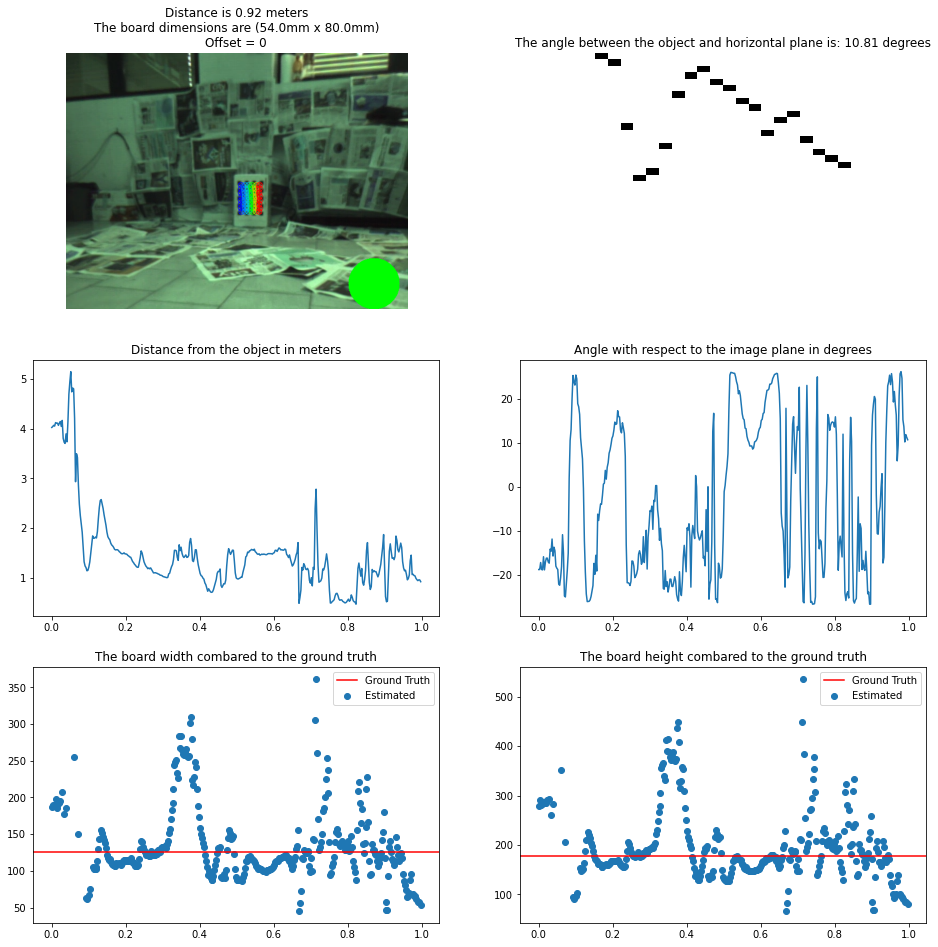

Released Left video resource !!


In [6]:
disparityRange = 128
imageSize = 40
windowSize =  11
PATH = 'Resources/'
s = StereoRobot(PATH,imageSize,disparityRange,windowSize,filterOutliers=False,offset=False, n_stripes=20, uniqunessRatio=0.8)
s.acquire()

### As it is observed in the above plots specifically in the bottom left and right plots the accuracy of the values of the estimated width and height of the internal corners of the chess board gets higher as the vehicle gets closer to the board. But in the second manueveur the accuracy is lower as it is noted in the time interval after 0.7 seconds that is because the angle of the plane that contains the chessboard and the image plane is relatively high so the accuracy of the estimate becomes worse in that time interval. So to sum up when the vehicle gets closer to the chessboard the accuracy of the estimate becomes higher as long as the plane of the chessboard and the image are parallel. And on the other hand the accurcy of the estimate becomes more worse when the angle between the two planes increases.

### The application with the disparity offset and without filtering the outliers

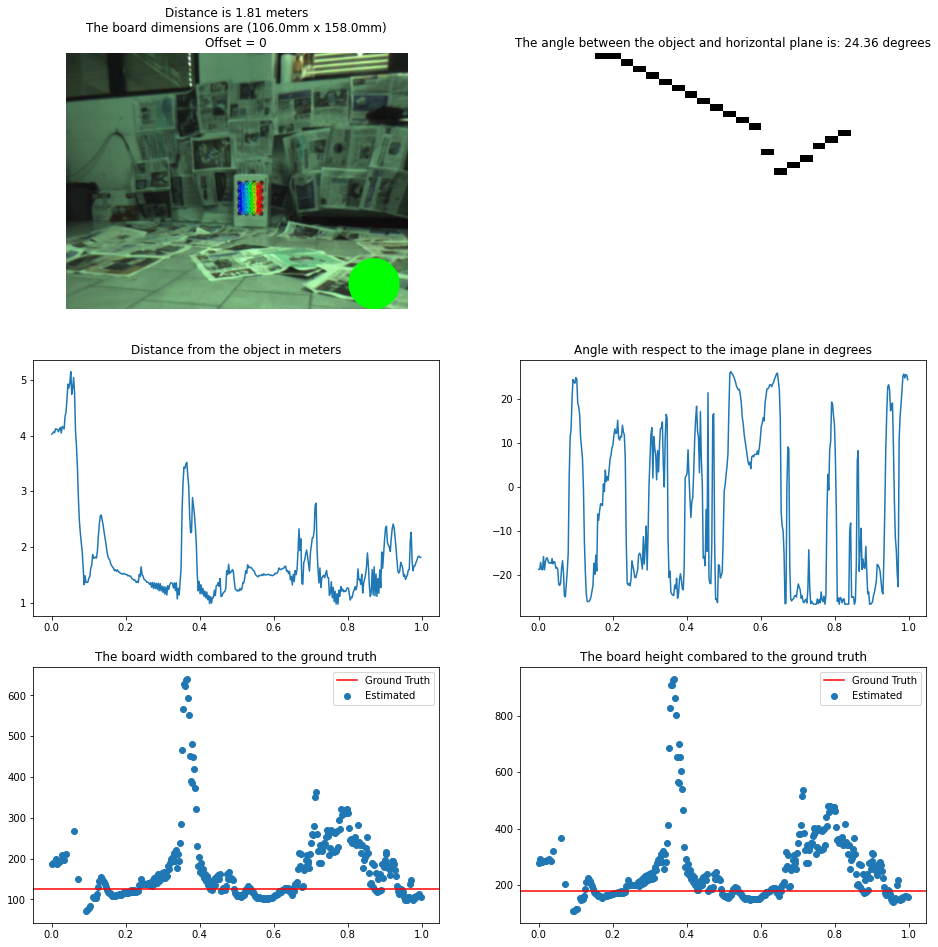

Released Left video resource !!


In [7]:
disparityRange = 64
imageSize = 40
windowSize =  11
PATH = 'Resources/'
s = StereoRobot(PATH,imageSize,disparityRange,windowSize,filterOutliers=False,offset=True, n_stripes=20, uniqunessRatio=0.8)
s.acquire()

### The application with the disparity offset and with filtering the outliers

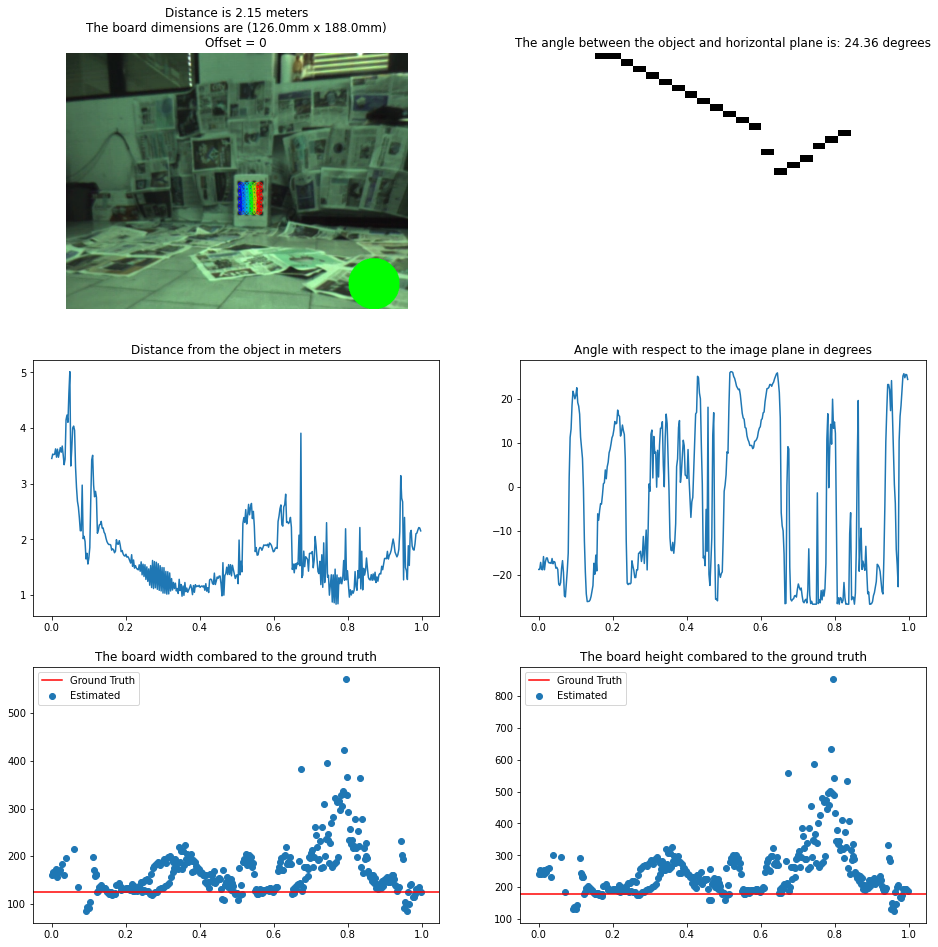

Released Left video resource !!


In [8]:
disparityRange = 64
imageSize = 40
windowSize =  11
PATH = 'Resources/'
s = StereoRobot(PATH,imageSize,disparityRange,windowSize,filterOutliers=True, offset=True, n_stripes=20, uniqunessRatio=0.8)
s.acquire()

## References
### [1] L. Di Stefano, M. Marchionni, S. Mattoccia, G. Neri et al. A Fast Area-Based Stereo Matching Algorithm

### [2] Stefano Mattoccia http://vision.deis.unibo.it/~smatt/Seminars/StereoVision.pdf